<a href="https://colab.research.google.com/github/Guilli12pm/ML_proj/blob/master/kNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning project: kNN

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()
tf.__version__

from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

import pathlib
import random
from statistics import mode, StatisticsError
import timeit

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

##Download the images

In [3]:
#https://github.com/Guilli12pm/ML_proj/raw/master/next_ite.tar.gz

data_root_orig = tf.keras.utils.get_file('new_pic',
                                         'https://github.com/Guilli12pm/ML_proj/raw/master/new_pic.tar.gz',
                                         untar=True)
data_root = pathlib.Path(data_root_orig)
for item in data_root.iterdir():
  print(item)

/root/.keras/datasets/new_pic/Guillaume_Loranchet
/root/.keras/datasets/new_pic/.DS_Store
/root/.keras/datasets/new_pic/Guillaume_Paya


In [4]:
data_root_orig_1 = tf.keras.utils.get_file('new_pic(1)',
                                         'https://github.com/Guilli12pm/ML_proj/raw/master/new_pic(1).tar.gz',
                                         untar=True)
data_root_1 = pathlib.Path(data_root_orig_1)
for item in data_root_1.iterdir():
  print(item)

/root/.keras/datasets/new_pic(1)/.DS_Store
/root/.keras/datasets/new_pic(1)/Miha_S


In [5]:
data_root_orig_2 = tf.keras.utils.get_file('new_pic(2)',
                                         'https://github.com/Guilli12pm/ML_proj/raw/master/new_pic(2).tar.gz',
                                         untar=True)
data_root_2 = pathlib.Path(data_root_orig_2)
for item in data_root_2.iterdir():
  print(item)

/root/.keras/datasets/new_pic(2)/.DS_Store
/root/.keras/datasets/new_pic(2)/Nicholas_S


In [6]:
data_root_orig_test = tf.keras.utils.get_file('next_ite',
                                         'https://github.com/Guilli12pm/ML_proj/raw/master/result.tar.gz',
                                         untar=True)
data_root_test = pathlib.Path(data_root_orig_test)
for item in data_root_test.iterdir():
  print(item)

/root/.keras/datasets/next_ite/Guillaume_Loranchet
/root/.keras/datasets/next_ite/.DS_Store
/root/.keras/datasets/next_ite/Guillaume_Paya
/root/.keras/datasets/next_ite/Nicholas_S
/root/.keras/datasets/next_ite/Miha_S


##Inspect the dataset

In [0]:
all_image_paths_0 = list(data_root.glob('*/*'))
all_image_paths_1 = list(data_root_1.glob('*/*'))
all_image_paths_2 = list(data_root_2.glob('*/*'))

all_image_paths_train = all_image_paths_2 + all_image_paths_1 + all_image_paths_0

all_image_paths_train = [str(path) for path in all_image_paths_train]
random.shuffle(all_image_paths_train)

all_image_paths_test = list(data_root_test.glob('*/*'))

all_image_paths_test = [str(path) for path in all_image_paths_test]
random.shuffle(all_image_paths_test)

image_count_train = len(all_image_paths_train)

In [8]:
all_image_paths_train[:5]

['/root/.keras/datasets/new_pic/Guillaume_Loranchet/Guillaume_Loranchet_88_blurred_2_rot_clock_2.png',
 '/root/.keras/datasets/new_pic(2)/Nicholas_S/Nicholas_9_sp_5_rot_anty_0.png',
 '/root/.keras/datasets/new_pic/Guillaume_Loranchet/Guillaume_Loranchet_17_sharpened_2_5_rot_clock_1.png',
 '/root/.keras/datasets/new_pic/Guillaume_Paya/Guillaume_Paya_42_sp_9_rot_anty_2.png',
 '/root/.keras/datasets/new_pic(1)/Miha_S/Miha_S_78_sharpened_1_6.png']

In [9]:
all_image_paths_test[:5]

['/root/.keras/datasets/next_ite/Guillaume_Paya/Guillaume_Paya_97.png',
 '/root/.keras/datasets/next_ite/Guillaume_Paya/Guillaume_Paya_70.png',
 '/root/.keras/datasets/next_ite/Guillaume_Loranchet/Guillaume_Loranchet_114.png',
 '/root/.keras/datasets/next_ite/Guillaume_Loranchet/Guillaume_Loranchet_92.png',
 '/root/.keras/datasets/next_ite/Guillaume_Loranchet/Guillaume_Loranchet_60.png']

###Show images

Training images


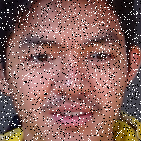

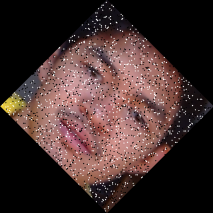


Testing images


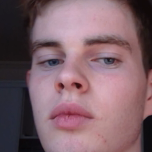

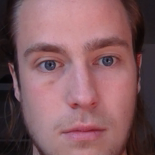

In [10]:
import IPython.display as display

print('Training images')
for n in range(2):
  image_path = random.choice(all_image_paths_train)
  #print('image path: ',image_path)
  display.display(display.Image(image_path))

print('\nTesting images')
for n in range(2):
  image_path = random.choice(all_image_paths_test)
  #print('image path: ',image_path)
  display.display(display.Image(image_path))

###Label images

In [11]:
label_names_0 = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names_1 = sorted(item.name for item in data_root_1.glob('*/') if item.is_dir())
label_names_2 = sorted(item.name for item in data_root_2.glob('*/') if item.is_dir())

label_names = label_names_0 + label_names_1 + label_names_2
label_names

['Guillaume_Loranchet', 'Guillaume_Paya', 'Miha_S', 'Nicholas_S']

In [12]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'Guillaume_Loranchet': 0, 'Guillaume_Paya': 1, 'Miha_S': 2, 'Nicholas_S': 3}

In [0]:
for name in label_names:
  stri = '/root/.keras/datasets/next_ite/' + name + '/.DS_Store'
  if stri in all_image_paths_test:
    all_image_paths_test.remove(stri)
  stri = '/root/.keras/datasets/next_ite/' + name + '/._.DS_Store'
  if stri in all_image_paths_test:
    all_image_paths_test.remove(stri)

In [14]:
all_image_labels_train = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths_train]

print("First 10 labels indices of training set: ", all_image_labels_train[:10])

all_image_labels_test = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths_test]

print("First 10 labels indices of training set: ", all_image_labels_test[:10])

First 10 labels indices of training set:  [0, 3, 0, 1, 2, 3, 2, 3, 0, 1]
First 10 labels indices of training set:  [1, 1, 0, 0, 0, 0, 1, 3, 2, 3]


###Load images with Tensor Flow

In [15]:
img_path = all_image_paths_train[0]
img_path

'/root/.keras/datasets/new_pic/Guillaume_Loranchet/Guillaume_Loranchet_88_blurred_2_rot_clock_2.png'

In [0]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])

  return image

def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

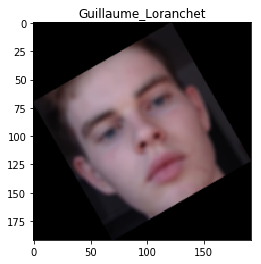

In [17]:
image_path = all_image_paths_train[0]
label = all_image_labels_train[0]

plt.imshow(load_and_preprocess_image(image_path)/255)
plt.grid(False)
#plt.xlabel(caption_image(img_path).encode('utf-8'))
plt.title(label_names[label].title())
print()

In [18]:
n_train = len(all_image_paths_train)

x_train_aux = [load_and_preprocess_image(all_image_paths_train[i]) for i in range(n_train)]
x_train_aux_2 = np.array([np.array(x_train_aux[i]) for i in range(n_train)])
x_train = x_train_aux_2 / 255   #normalize between 0 and 1

n_test = len(all_image_paths_test)

x_test_aux = [load_and_preprocess_image(all_image_paths_test[i]) for i in range(n_test)]
x_test_aux_2 = np.array([np.array(x_test_aux[i]) for i in range(n_test)])
x_test = x_test_aux_2 / 255   #normalize between 0 and 1
print(x_train.shape)
print(x_test.shape)

y_train = np.array([[0]*i + [1] + [0]*(len(label_names)-1-i) for i in all_image_labels_train])
y_test = np.array([[0]*i + [1] + [0]*(len(label_names)-1-i) for i in all_image_labels_test])
print(y_train.shape)
print(y_test.shape)

labels = label_names
print(labels)

print(y_train[0])

(4140, 192, 192, 3)
(439, 192, 192, 3)
(4140, 4)
(439, 4)
['Guillaume_Loranchet', 'Guillaume_Paya', 'Miha_S', 'Nicholas_S']
[1 0 0 0]


(4140, 4)


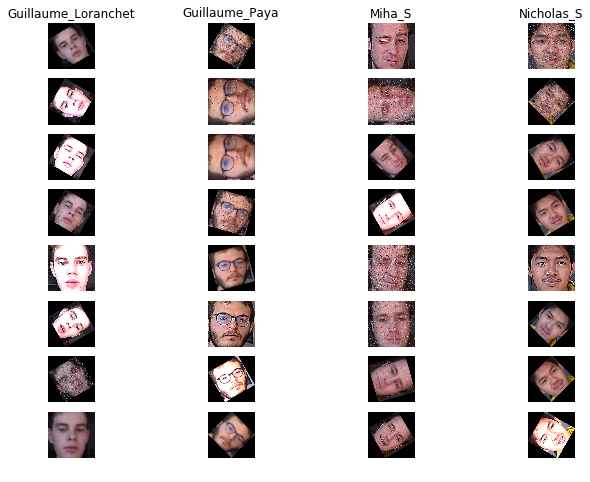

In [19]:
def show_first_n_images_in_categories(n, images, categories, labels, file_name=None):
    """Plots the first n images in each category from the image data."""
    f, axes = plt.subplots(n, len(categories[0]), figsize=(11,8))
    print(categories.shape)
    for i in range(len(categories[0])):
        count = 0
        j = 0
        while count < n and j < len(categories):
            #print(j,i)
            if categories[j][i] == 1:
                axes[count,i].imshow(images[j,:,:,:])
                axes[count,i].axis('off')
                if count == 0:
                    axes[count,i].set_title(labels[i])
                count += 1
            j += 1

    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

show_first_n_images_in_categories(8, x_train, y_train, labels)

##kNN Model

In [20]:
def euclidean_distance(ima_1,ima_2):
  return np.sqrt(sum(sum(sum((ima_1-ima_2)**2))))

print(euclidean_distance(x_train[0],x_train[1]))

111.16271483695365


In [21]:
def test(ima_test,label):
  print(label)
  x1, x2, x3, x4 = [],[],[],[]
  for i in range(0,100):
    if y_train[i][0]:
      x1.append(euclidean_distance(ima_test,x_train[i]))
    elif y_train[i][1]:
      x2.append(euclidean_distance(ima_test,x_train[i]))
    elif y_train[i][2]:
      x3.append(euclidean_distance(ima_test,x_train[i]))
    elif y_train[i][3]:
      x4.append(euclidean_distance(ima_test,x_train[i]))

  liste = [np.mean(x1),np.mean(x2),np.mean(x3),np.mean(x4)]
  return liste

test(x_test[32],y_test[32])

[1 0 0 0]


[93.22258173807786, 88.43633942050987, 84.64420014239502, 84.54495048257236]

In [0]:
def average(liste):
  return sum(liste)/len(liste)

In [0]:
def clustering(x,y,k):
  nb_pers = len(y[0])  #4
  res = [[] for _ in range(nb_pers)]
  intermediate = [[] for _ in range(nb_pers)]
  
  for i in range(len(x)):
    for j in range(nb_pers):
      if len(intermediate[j]) == k:   #make groups of size k
        res[j].append(average(intermediate[j]))  
        intermediate[j] = []
    for j in range(nb_pers):
      if y[i][j]:   # i-th picture represent the j-th person in labels
        intermediate[j].append(x[i])
  for j in range(nb_pers):
    if len(intermediate[j]) != 0:
      res[j].append(average(intermediate[j])) 
  return res
        

A = clustering(x_train,y_train,100)

In [24]:
def try_mode(liste):
  '''check if there are more than 1 mode'''
  try:
    return mode(liste)
  except StatisticsError:
    return -1
  
B = [1,2,3]
try_mode(B)

-1

In [0]:
A = clustering(x_train,y_train,5)

def kNN(ima_input,A,k):  
  res_aux = {}
  for i in range(len(A)):
    for j in range(len(A[i])):
      res_aux[euclidean_distance(ima_input,A[i][j])] = i
        
  res = [value for (key,value) in sorted(res_aux.items())]   #take only the first k closest element
  #print(res)
  while try_mode(res[:k]) == -1:  #return the most frequent element
    k += 1
  return mode(res[:k])
  
  
def test_knn(A,k):
  res = 0
  for i in range(len(y_test)):
    val = kNN(x_test[i],A,k)
    if y_test[i][val]:
      res += 1
  return res/len(y_test)  

In [26]:
n = len(y_test)

def test_final():
  for i in [1,2,3,4,5,6,7,8]:
    A = clustering(x_train,y_train,i)
    def test_time():
      print('Cluster of {} elements'.format(i))
      print('Accuracy: ',test_knn(A,3))

    print('Time to predict each picture',timeit.timeit(test_time,number=1)/n,'\n')
    
test_final()

Cluster of 1 elements
Accuracy:  0.8815489749430524
Time to predict each picture 1.621962771571754 

Cluster of 2 elements
Accuracy:  0.8952164009111617
Time to predict each picture 0.822498746020502 

Cluster of 3 elements
Accuracy:  0.8747152619589977
Time to predict each picture 0.7807300900546698 

Cluster of 4 elements
Accuracy:  0.9043280182232346
Time to predict each picture 0.4145117971435072 

Cluster of 5 elements
Accuracy:  0.8747152619589977
Time to predict each picture 0.7066861600022774 

Cluster of 6 elements
Accuracy:  0.8701594533029613
Time to predict each picture 0.2750192653462417 

Cluster of 7 elements
Accuracy:  0.8724373576309795
Time to predict each picture 0.3777576999931675 

Cluster of 8 elements
Accuracy:  0.8633257403189066
Time to predict each picture 0.23307825262870246 



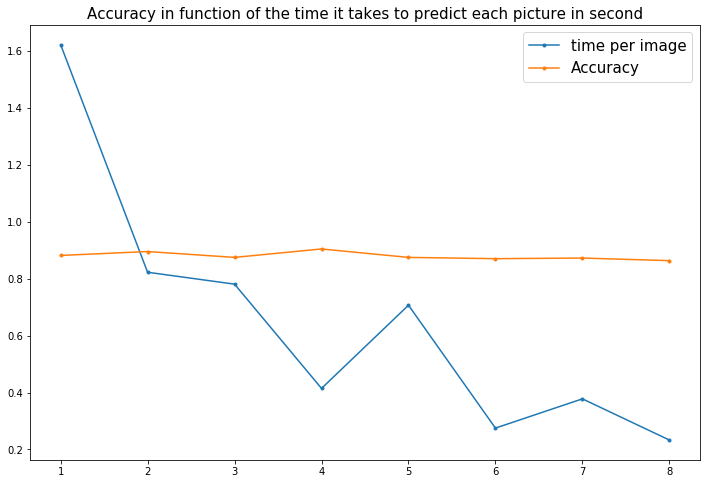

In [52]:
A = [1.621962771571754,0.822498746020502,0.7807300900546698,0.4145117971435072,0.7066861600022774 ,0.2750192653462417,0.3777576999931675,0.23307825262870246]
B = [0.8815489749430524,0.8952164009111617,0.8747152619589977,0.9043280182232346,0.8747152619589977,0.8701594533029613,0.8724373576309795,0.8633257403189066]
C = [i for i in range(1,9)]

plt.figure(figsize=(12,8))
#plt.plot(A[0],B[0])
plt.plot(C,A,marker='.')
plt.plot(C,B,marker='.')
plt.title('Accuracy in function of the time it takes to predict each picture in second',fontsize=15)
plt.legend(('time per image','Accuracy'),loc='best',fontsize=15)
plt.show()